In [3]:
import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')
#from generator import DataGenerator


### Creating data for model

In [3]:
data = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
# removing datapoints which having age greater than 100
data = data[data['Patient Age'] < 100]
data_image_paths = {os.path.basename(x): x for x in
                    glob(os.path.join('/kaggle/input/data', 'images_*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
86277,00021277_001.png,Effusion|Infiltration,1,21277,19,M,AP,3016,2544,0.139,0.139,NaN,/kaggle/input/data/images_010/images/00021277_...
2186,00000573_012.png,Nodule,12,573,52,M,PA,2992,2991,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000573_...
86167,00021251_001.png,Atelectasis,1,21251,52,M,AP,3056,2544,0.139,0.139,NaN,/kaggle/input/data/images_010/images/00021251_...


### Preprocessing Labels

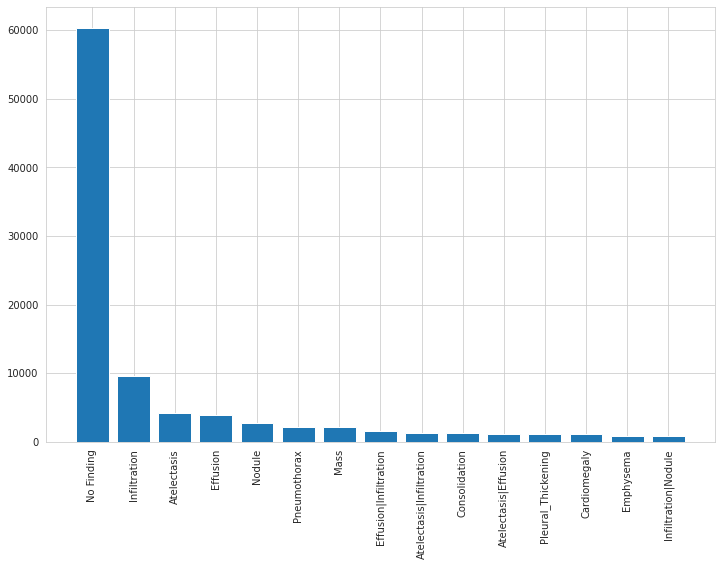

In [4]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation=90)


In [5]:
from itertools import chain
data['Finding Labels'] = data['Finding Labels'].map(
    lambda x: x.replace('No Finding', ''))
# data = data[data['Finding Labels'] != 'No Finding']
all_labels = np.unique(
    list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1:  # leave out empty labels
        data[c_label] = data['Finding Labels'].map(
            lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
11492,00003026_001.png,Pneumothorax,1,3026,50,F,PA,2510,2573,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89792,00022292_000.png,,0,22292,27,F,PA,2546,2947,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13121,00003421_006.png,,6,3421,41,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Clean categories
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()
              > MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label, int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


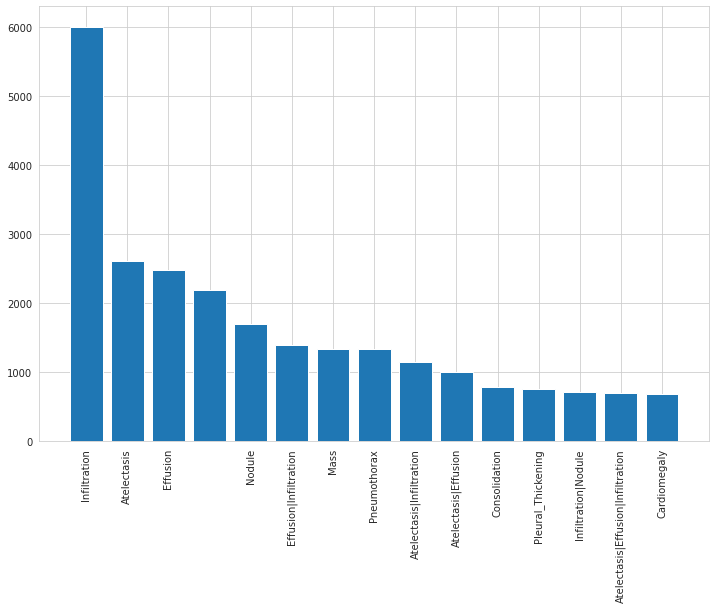

In [7]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(
    lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation=90)


### Prepare Training Data

In [8]:
# creating vector of diseases
data['disease_vec'] = data.apply(
    lambda x: x['Finding Labels'].split('|'), axis=1)


In [9]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))


In [10]:
valid_df, test_df = train_test_split(valid_df, 
                                   test_size = 0.50, 
                                   random_state = 2018,
                                   stratify = valid_df['Finding Labels'].map(lambda x: x[:4]))

In [11]:
print('train', train_df.shape[0], 'valid', valid_df.shape[0], 'test', test_df.shape[0])

train 32000 valid 4000 test 4000


### Create Data Generators

In [12]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip=True,
                              vertical_flip=False,
                              height_shift_range=0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)


In [13]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col='disease_vec',
                                         class_mode='categorical',
                                         classes=all_labels,
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         batch_size=32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col='disease_vec',
                                         class_mode='categorical',
                                         classes=all_labels,
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         batch_size=256)  # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col='disease_vec',
                                                   class_mode='categorical',
                                                   classes=all_labels,
                                                   target_size=IMG_SIZE,
                                                   color_mode='rgb',
                                                   batch_size=1024))


Found 30193 validated image filenames belonging to 13 classes.
Found 3773 validated image filenames belonging to 13 classes.
Found 3775 validated image filenames belonging to 13 classes.


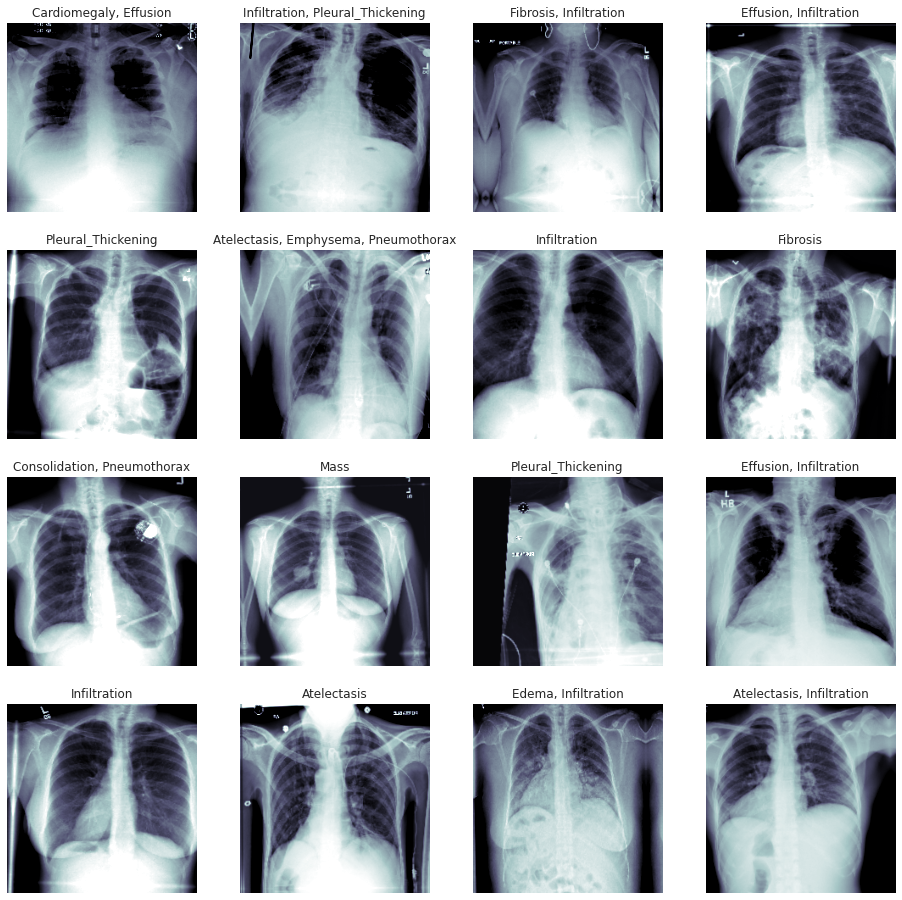

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:, :, 0], cmap='bone', vmin=-1.5, vmax=1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score > 0.5]))
    c_ax.axis('off')


### Creat DenseNet Model

In [15]:
from keras.applications.densenet import DenseNet121, preprocess_input

In [ ]:
img_in = Input(t_x.shape[1:])
model = DenseNet121(include_top= False ,
                    weights='imagenet',
                    input_tensor= img_in, 
                    input_shape= t_x.shape[1:],
                    pooling ='avg') 

x = model.output  
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_in, outputs=predictions)

In [17]:
model.compile(optimizer=Adam(), loss="binary_crossentropy",
              metrics=[keras.metrics.AUC(multi_label=True)])


### Train Model

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [19]:
# 設定earlystop條件
estop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# 設定模型儲存條件
checkpoint = ModelCheckpoint('model_checkpoint.h5', verbose=1,
                          monitor='val_loss', save_best_only=True,
                          mode='min')

# 設定lr降低條件(0.001 → 0.0005 → 0.00025 → 0.000125 → 0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                           patience=5, mode='min', verbose=1,
                           min_lr=1e-5)

In [ ]:
history = model.fit_generator(train_gen,
                              validation_data=valid_gen,
                              epochs=20,
                              callbacks=[checkpoint, estop, reduce_lr])


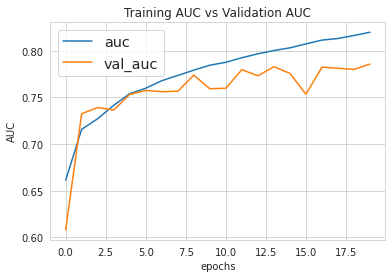

In [17]:
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title('Training AUC vs Validation AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend(fontsize = 'x-large')
plt.savefig('auc.jpg')

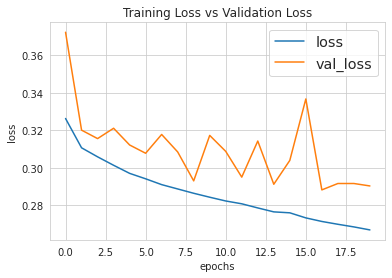

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(fontsize = 'x-large')
plt.savefig('loss.jpg')

### Check Output

In [53]:
import tensorflow as tf
model = tf.keras.models.load_model('model_checkpoint.h5')

In [54]:
y_pred = model.predict(test_X)


In [57]:
# look at how often the algorithm predicts certain diagnoses
for c_label, p_count, t_count in zip(all_labels,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' %
          (c_label, t_count, p_count))


Atelectasis: actual: 24.71%, predicted: 28.25%
Cardiomegaly: actual: 6.05%, predicted: 4.85%
Consolidation: actual: 9.57%, predicted: 10.44%
Edema: actual: 5.37%, predicted: 5.39%
Effusion: actual: 28.61%, predicted: 30.19%
Emphysema: actual: 5.18%, predicted: 4.72%
Fibrosis: actual: 3.22%, predicted: 3.49%
Infiltration: actual: 41.11%, predicted: 42.52%
Mass: actual: 10.94%, predicted: 9.43%
Nodule: actual: 13.48%, predicted: 10.81%
Pleural_Thickening: actual: 7.13%, predicted: 7.40%
Pneumonia: actual: 2.83%, predicted: 3.47%
Pneumothorax: actual: 11.04%, predicted: 10.28%


### ROC Curves

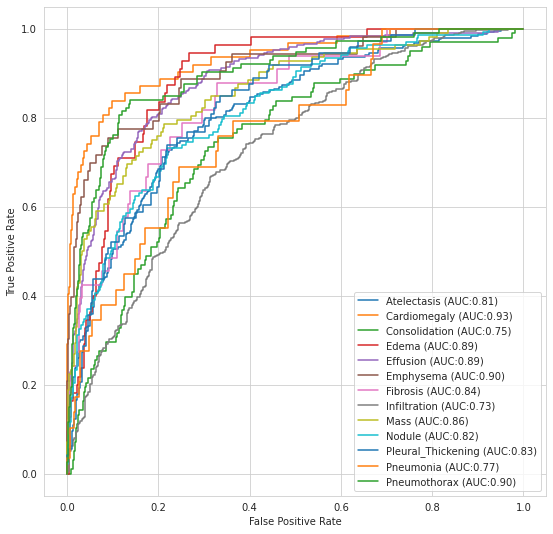

In [56]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(
        test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')


In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y.astype(int), y_pred)


0.8387477037600626